

<figure>
   <IMG SRC="https://avatars2.githubusercontent.com/u/31697400?s=400&u=a5a6fc31ec93c07853dd53835936fd90c44f7483&v=4" WIDTH=125 ALIGN="right">
</figure>
    
# NLmod examples    

This example notebook shows some examples of the `nlmod` package. This package contains functions to create modflow models anywhere in the Netherlands.

### Table of contents
1. [Create model](#create)
2. [Run model](#run)
3. [Visualise](#Visualise)
4. [Local grid refinement](#local)

In [1]:
import matplotlib.pyplot as plt
import flopy
import os
import geopandas as gpd

import nlmod

print(f'nlmod version: {nlmod.__version__}')

nlmod version: 0.0.1b


### 1. Create model<a name="create"></a>

With the code below we create a modflow model named 'IJmuiden'. This model has the following properties (most of which are default settings in the `gen_model_structured` function):
- an extent that covers part of the Northsea, Noordzeekanaal and the small port city IJmuiden.
- a structured grid based on the subsurface models [Regis](https://www.dinoloket.nl/regis-ii-het-hydrogeologische-model) and [Geotop](https://www.dinoloket.nl/detaillering-van-de-bovenste-lagen-met-geotop). The Regis layers that are not present within the extent are removed. In this case we use b'MSz1' as the bottom layer of the model. Use `nlmod.regis.get_layer_names()` to get all the layer names of Regis. All Regis layers below this layer are not used in the model. Geotop is used to replace the holoceen layer in Regis because there is no kh or kv defined for the holoceen in Regis. Part of the model is in the North sea. Regis and Geotop have no data there. Therefore the Regis and Geotop layers are extrapolated from the shore and the seabed is added using bathymetry data from [Jarkus](https://www.openearth.nl/rws-bathymetry/2018.html).
- starting heads of 1 in every cell.
- A steady state model is created.
- big surface water bodies (Northsea, IJsselmeer, Markermeer, Noordzeekanaal) within the extent are added as a general head boundary. The surface water bodies are obtained from a [shapefile](..\data\opp_water.shp).
- surface drainage is added using [ahn](https://www.ahn.nl) data and a default conductance of $1000 m^2/d$
- recharge is added using data from the [knmi](https://www.knmi.nl/nederland-nu/klimatologie/daggegevens) using the following steps:
    1. Check for each cell which KNMI weather and/or rainfall station is closest.
    2. Download the data for the stations found in 1. for the model period. For a steady state stress period the average precipitation and evaporation of 8 years before the stress period time is used.
    3. Combine precipitation and evaporation data from step 2 to create a recharge time series for each cell
    4. Add the timeseries to the model dataset and create the recharge package.
- constant head boundaries are added to the model edges in every layer. The starting head is used as constant head.

In [2]:
model_ds, gwf = nlmod.create_model.gen_model_structured('model1', 'IJmuiden',
                                                        use_cache=False,
                                                        extent=[95000., 105000., 494000., 500000.],
                                                        steady_state=True, 
                                                        regis_botm_layer=b'MSz1',
                                                        verbose=True)

creating modflow SIM, TDIS, GWF and IMS
redefining current extent: [95000.0, 105000.0, 494000.0, 500000.0], fit to regis raster
new extent is [94950.0, 105050.0, 493950.0, 500050.0] model has 61 rows and 101 columns
creating and caching dataset combined_layer_ds.nc

add kh and kv from model layer dataset to modflow model
layer 0 has a kh
layer 1 has a kh
layer 2 has a kh
layer 3 has a kh
layer 4 has a kh
layer 5 has a kh
layer 6 has a kh
layer 7 has a kh
layer 8 has a kh
layer 9 has a kh
layer 10 has a kh
layer 11 has a kh
layer 12 has a kh
layer 13 has a kh
layer 14 has a kv
layer 15 has a kh
layer 16 has a kv
layer 17 has a kh
layer 18 has a kh
layer 19 has a kv
layer 20 has a kh
layer 21 has a kv
layer 22 has a kh
layer 23 has a kh
layer 24 has a kh
layer 25 has a kh
layer 26 has a kv
layer 27 has a kh
layer 28 has a kh
layer 29 has a kv
layer 30 has a kh
layer 31 has a kh
layer 32 has a kh
layer 33 has a kv
layer 34 has a kh
layer 35 has a kv
layer 36 has a kh
layer 37 has a kh
lay

A big part of the model data is stored in the variable `model_ds` which is an `xarray.Dataset`. The data is shown below.

In [3]:
model_ds

<xarray.Dataset>
Dimensions:             (layer: 40, time: 1, x: 101, y: 61)
Coordinates:
  * time                (time) datetime64[ns] 2015-01-01
  * x                   (x) float64 9.5e+04 9.51e+04 ... 1.049e+05 1.05e+05
  * y                   (y) float64 5e+05 4.999e+05 ... 4.941e+05 4.94e+05
  * layer               (layer) object 'AAOP' 'NASC' 'ONAWA' ... 'PZWAz4' 'MSz1'
Data variables:
    time_steps          (time) int32 0
    idomain             (layer, y, x) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    first_active_layer  (y, x) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    bot                 (layer, y, x) float64 -12.66 -12.66 ... -218.5 -218.8
    top                 (y, x) float64 0.0 0.0 0.0 0.0 ... 1.49 0.5 0.37 0.37
    kh                  (layer, y, x) float64 10.0 10.0 10.0 ... 6.11 6.11 6.12
    kv                  (layer, y, x) float64 10.0 10.0 10.0 ... 0.611 0.612
    northsea            (y, x) float64 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    bathymetry          (y, x) float64 -12.66 -12.66 -12.66 ... nan nan nan
    thickness           (layer, y, x) float64 12.66 12.66 12.66 ... 0.13 0.09999
    starting_head       (layer, y, x) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    surface_water_area  (y, x) float64 1e+04 1e+04 1e+04 1e+04 ... 0.0 0.0 0.0
    surface_water_cond  (y, x) float64 1e+03 1e+03 1e+03 1e+03 ... 0.0 0.0 0.0
    surface_water_peil  (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ahn                 (y, x) float64 nan nan nan nan ... 1.383 0.06108 0.2178
    recharge            (y, x) float64 0.0006817 0.0006817 ... 0.0009298
    chd                 (layer, y, x) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes:
    model_name:        IJmuiden
    model_ws:          model1
    time_units:        DAYS
    start_time:        2015-01-01 00:00:00
    nper:              1
    perlen:            1.0
    nstp:              1
    tsmult:            1.0
    mfversion:         mf6
    steady_start:      1
    steady_state:      1
    gridtype:          structured
    extent:            [94950.0, 105050.0, 493950.0, 500050.0]
    delr:              100.0
    delc:              100.0
    nodata:            -999
    anisotropy:        10
    fill_value_kh:     1.0
    fill_value_kv:     0.1
    surface_drn_cond:  1000

### 2. Run<a name="run"></a>
The model that we've created has not been runned yet. When you want to save and run the model you can set the keyword arguments `write_sim` and `run_sim` to `True` in the `gen_model_structured` function. You can also run the model using the code below.

Note: You always have to write the modflow data to the model workspace before you can run the model. 

In [4]:
gwf.simulation.write_simulation()
gwf.simulation.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model IJmuiden...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package oc...
    writing package ghb_0...
    writing package drn_0...
    writing package ijmuiden...
    writing package chd...
FloPy is using the following  executable to run the model: C:\Users\oebbe\04_software\executables\mf6.EXE
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.0 10/22/2020

   MODFLOW 6 compiled Oct 22 2020 09:26:42 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. 

(True, [])

### 3. Visualise<a name="visualise"></a>

Using the `model_ds` and `gwf` variables it is quite easy to visualise model data. Below the modelgrid together with the surface water is shown.

In [5]:
# get figdir to save figures
figdir, cachedir = nlmod.util.get_model_dirs(model_ds.model_ws, gridtype=model_ds.gridtype)

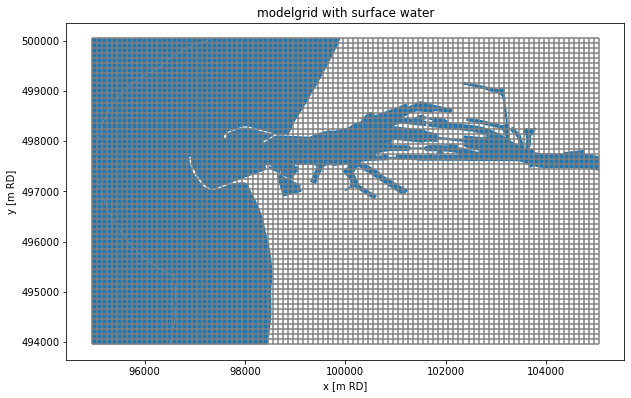

In [6]:
ax = nlmod.plots.plot_modelgrid(model_ds, gwf)
ax.figure.savefig(os.path.join(figdir, 'mgrid_swater.png'), bbox_inches='tight')

Data from a model with a structured grid can be easily visualised using the model dataset. Below some examples

In [7]:
model_ds['recharge']

<xarray.DataArray 'recharge' (y: 61, x: 101)>
array([[0.0006817 , 0.0006817 , 0.0006817 , ..., 0.0006817 , 0.0006817 ,
        0.0006817 ],
       [0.0006817 , 0.0006817 , 0.0006817 , ..., 0.0006817 , 0.0006817 ,
        0.0006817 ],
       [0.0006817 , 0.0006817 , 0.0006817 , ..., 0.0006817 , 0.0006817 ,
        0.0006817 ],
       ...,
       [0.00093063, 0.00093063, 0.00093063, ..., 0.00092979, 0.00092979,
        0.00092979],
       [0.00093063, 0.00093063, 0.00093063, ..., 0.00092979, 0.00092979,
        0.00092979],
       [0.00093063, 0.00093063, 0.00093063, ..., 0.00092979, 0.00092979,
        0.00092979]])
Coordinates:
  * x        (x) float64 9.5e+04 9.51e+04 9.52e+04 ... 1.049e+05 1.05e+05
  * y        (y) float64 5e+05 4.999e+05 4.998e+05 ... 4.941e+05 4.94e+05

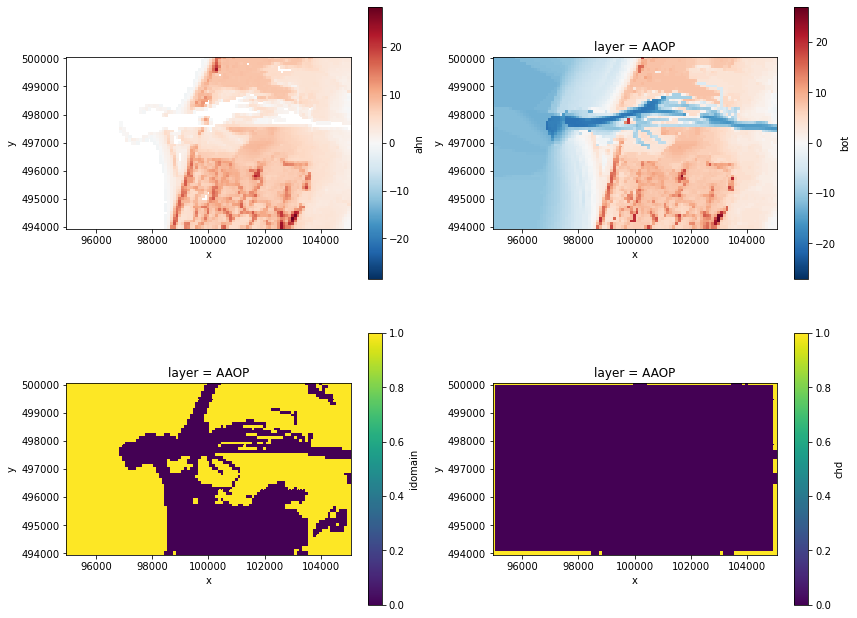

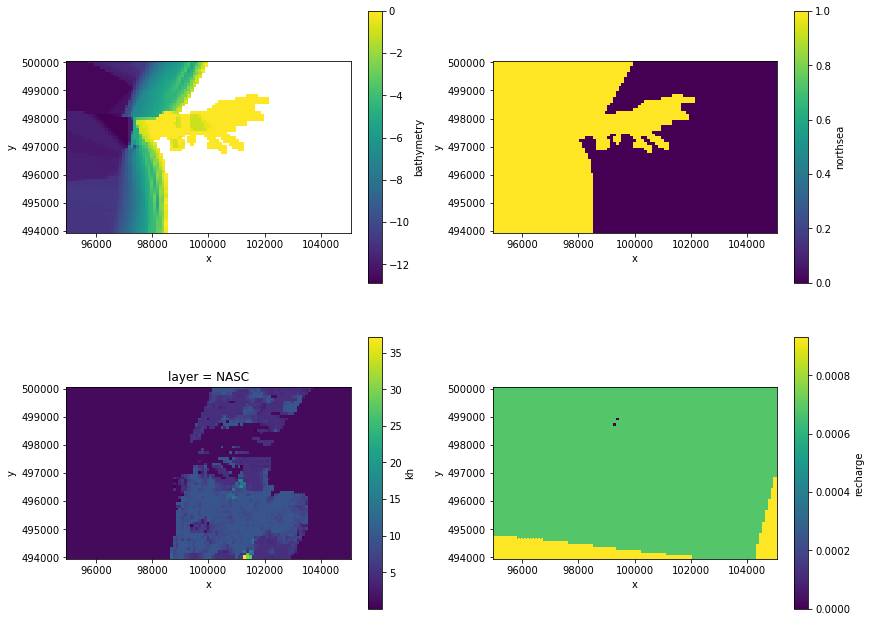

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,11))
model_ds['ahn'].plot(ax=axes[0][0])
model_ds['bot'][0].plot(ax=axes[0][1])
model_ds['idomain'][0].plot(ax=axes[1][0])
model_ds['chd'][0].plot(ax=axes[1][1])
for axes1 in axes:
    for ax in axes1:
        ax.axis('scaled')

fig.savefig(os.path.join(figdir, 'ahn_bot_idom_chd.png'), bbox_inches='tight')        
        
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,11))
model_ds['bathymetry'].plot(ax=axes[0][0])
model_ds['northsea'].plot(ax=axes[0][1])
model_ds['kh'][1].plot(ax=axes[1][0])
model_ds['recharge'].plot(ax=axes[1][1])

for axes1 in axes:
    for ax in axes1:
        ax.axis('scaled')
fig.savefig(os.path.join(figdir, 'bath_nsea_kh_rch.png'), bbox_inches='tight')        

### 4. Local grid refinement<a name="local"></a>

Modflow 6 makes it possible to use locally refined grids. In NLmod you can use a shapefile and a number of levels to specify where and how much you want to use local grid refinement. Below we use a shapefile of the Planetenweg in IJmuiden and set the refinement levels at 2. This well create a grid with cells of 100x100m except at the Planetenweg where the cells will be refined to 25x25m. See also figures below.

Note: the `gen_model_unstructured` function also returns the `gridprops` dictionary. This contains data that is necesary to create some packages. It can be time consuming to generate this data.

In [ ]:
refine_shp = os.path.join(nlmod.nlmod_datadir, 'shapes', 'planetenweg_ijmuiden')

model_ds2, gwf2, gridprops2 = nlmod.create_model.gen_model_unstructured('model2', 'IJm_planeten',
                                                                         use_cache=False,
                                                                         refine_shp_fname=refine_shp,
                                                                         levels=2,
                                                                         delr=100., delc=100.,
                                                                         extent=[95000., 105000., 494000., 500000.],
                                                                         run_sim=True, write_sim=True)

- from cache C:\Users\oebbe\AppData\Local\Temp\ahn\ahn3_5m_dtm\ahn_94950_105050_493950_500050_50.tiff


In [ ]:
# get figdir to save figures
figdir2, _, _=nlmod.util.get_model_dirs(model_ds2.model_ws,gridtype=model_ds2.gridtype)

In [ ]:
# plot modelgrid
ax = nlmod.plots.plot_modelgrid(model_ds2, gwf2)
gpd.read_file(refine_shp+'.shp').plot(ax=ax, color='r', label='Planetenweg')
ax.legend()
ax.get_figure().savefig(os.path.join(figdir2, 'mgrid_swater.png'), bbox_inches='tight')

# plot zoomed modelgrid
ax = nlmod.plots.plot_modelgrid(model_ds2, gwf2)
ax.set_title('Planetenweg')
gpd.read_file(refine_shp+'.shp').plot(ax=ax, color='r', label='Planetenweg')
ax.set_xlim(100000, 103000)
ax.set_ylim(495000,497500)
ax.legend()
ax.get_figure().savefig(os.path.join(figdir2, 'Planetenweg.png'), bbox_inches='tight')

The model dataset of an unstructured model differs from a structured model dataset. The data is stored relative to the cell-id instead of the row and column number. Therefore the model dataset has the dimension cid instead of the dimensions x and y. 

In [ ]:
model_ds2

To plot the same rasters as for the previous model we can use the `nlmod.plots.plot_array()` function.

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,11))
nlmod.plots.plot_array(gwf2, model_ds2['ahn'], ax=axes[0][0])
nlmod.plots.plot_array(gwf2, model_ds2['bot'][0], ax=axes[0][1])
nlmod.plots.plot_array(gwf2, model_ds2['idomain'][0], ax=axes[1][0])
nlmod.plots.plot_array(gwf2, model_ds2['chd'][0], ax=axes[1][1])

fig.savefig(os.path.join(figdir2, 'ahn_bot_idom_chd.png'), bbox_inches='tight')        
        
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,11))
nlmod.plots.plot_array(gwf2, model_ds2['bathymetry'],ax=axes[0][0])
nlmod.plots.plot_array(gwf2, model_ds2['northsea'],ax=axes[0][1])
nlmod.plots.plot_array(gwf2, model_ds2['kh'][1],ax=axes[1][0])

rain_series = model_ds2['recharge'][0,:].to_series()
rain_series.plot.bar(ax=axes[1][1])
axes[1][1].grid()
axes[1][1].set_title('recharge')

fig.savefig(os.path.join(figdir2, 'bath_nsea_kh_rch.png'), bbox_inches='tight')        